In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import glob
import torch
from torch import nn
import torch.nn.functional as F
import  torch.optim as optim
from    matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.rc('font',family='Times New Roman', size=16)

In [2]:
device

device(type='cuda')

In [3]:
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            if df_dup['is_anomaly'].iat[j] == 1:
                is_anomaly = True
        if is_anomaly:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame

In [4]:
def get_data():
    dataset_conc=[]
    path=r'../../Dataset'
    all_files=glob.glob(path+"/*.csv")
    for filename in all_files:
        df=pd.read_csv(filename,index_col=None,header=0)
        #将数据中value为0的替换成NaN
        df=df.replace(0,np.nan)
        #处理value那层数据，将0去除掉
        df=df.dropna(axis=0, how='any',subset=['value'])
        df.value = preprocessing.normalize([df.value]).T
        dataset_conc.append(convert_2d(df))
    frame=pd.concat(dataset_conc,axis=0,ignore_index=True)
    y = frame.iloc[:, 60]
    X = frame.iloc[:, 0:60]
    X_train = X[:int(X.shape[0] * 0.7)]
    X_test = X[int(X.shape[0] * 0.7):]
    y_train = y[:int(X.shape[0] * 0.7)]
    y_test = y[int(X.shape[0] * 0.7):]


    X_train = X_train.to_numpy()
    nrows, ncols = X_train.shape
    X_train = X_train.reshape(nrows, ncols, 1)

    X_test = X_test.to_numpy()
    nrows, ncols = X_test.shape
    X_test = X_test.reshape(nrows, ncols, 1)

    y_test = y_test.to_numpy()
    # print("X_train:",X_train.shape)
    #[62107,60,1]
    # print("y_train:",y_train.shape)
    #[62107,]
    return X_train,y_train,X_test,y_test

In [5]:
X_train,y_train,X_test,y_test=get_data()

In [6]:
X_test = torch.tensor(X_test).permute(0, 2, 1).to(torch.float32)
y_test=torch.tensor(y_test)

In [20]:
X_train

array([[[0.02393263],
        [0.04493904],
        [0.05900332],
        ...,
        [0.0085436 ],
        [0.01431762],
        [0.01787009]],

       [[0.04493904],
        [0.05900332],
        [0.0459983 ],
        ...,
        [0.01431762],
        [0.01787009],
        [0.01376995]],

       [[0.05900332],
        [0.0459983 ],
        [0.02360224],
        ...,
        [0.01787009],
        [0.01376995],
        [0.00622143]],

       ...,

       [[0.01675279],
        [0.01928905],
        [0.01928905],
        ...,
        [0.02671505],
        [0.02573092],
        [0.02598961]],

       [[0.01928905],
        [0.01928905],
        [0.01689901],
        ...,
        [0.02573092],
        [0.02598961],
        [0.02525853]],

       [[0.01928905],
        [0.01689901],
        [0.01999482],
        ...,
        [0.02598961],
        [0.02525853],
        [0.02514606]]])

In [7]:
import torch.utils.data as Data
from numpy import *

In [8]:
def test(model,x_test,y_test,flag):
    model.eval()
    torch_dataset=Data.TensorDataset(x_test,y_test)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        num_workers=0,  # 多进程（multiprocess）来读数据
    )

    acc = 0.0
    count = 0
    ans_labels=[]
    ans_pre=[]
    for index, data in enumerate(loader):
        inputs, labels = data  # 5,3,400,600  5,10
        count += len(labels)
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs = model(inputs)
        _, predict = torch.max(outputs, 1)
        acc += (labels == predict).sum().item()
        ans_labels+=labels.cpu().numpy().tolist()
        ans_pre+=predict.cpu().numpy().tolist()
    #evaluate performance
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    if flag==True:
      Confusion_Matrix = confusion_matrix(ans_labels, ans_pre)
      Accuracy = accuracy_score(ans_labels, ans_pre)
      precision = precision_score(ans_labels, ans_pre, average='binary')
      recall = recall_score(ans_labels, ans_pre, average='binary')
      F1_Score = f1_score(ans_labels, ans_pre, average='binary')
      print("Confusion_Matrix")
      print(Confusion_Matrix)
      print("Accuracy ", Accuracy)
      print("Precision ", precision)
      print("recall ", recall)
      print("f1_score ", F1_Score)
    return round(acc/count,4)

In [9]:
# 定义实现因果卷积的类
from torch.nn.utils import weight_norm
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# 定义了一个残差模块
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # n_inputs:输入通道数
        # n_outputs:输出通道数
        # stride：步长
        # padding:填充长度
        # dilation：扩张率
        # 定义第一个空洞卷积层
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # 根据第一个卷积层的输出与padding大小实现因果卷积
        self.chomp1 = Chomp1d(padding)
        # 添加激活函数与dropout正则化方法完成第一个卷积
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # 堆叠同样结构的第二个卷积层
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # 将卷积模块的所有组建通过Sequential方法依次堆叠在一起
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        # 如果输出纬度和输入维度不一致，则必须对输出进行1X1卷积
        # 如果通道数不一样，那么需要对输入x做一个逐元素的一维卷积以使得它的纬度与前面两个卷积相等。
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        # 不同激活函数的尝试
        # self.sigmod = nn.Softmax()
        # self.tanh = nn.Tanh()
        # self.softPlus = nn.Softplus()
        # self.leaky = nn.LeakyReLU()
        self.init_weights()

    # 初始化为从均值为0，标准差为0.01的正态分布中采样的随机值
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    # 结合卷积与输入的恒等映射（或输入的逐元素卷积），并投入ReLU 激活函数完成残差模块
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


# 时间卷积网络
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=5, dropout=0.5):
        super(TemporalConvNet, self).__init__()
        # num_input:输入特征数，默认为1
        # num_levels:网络层数，每一层是一个残差块
        # num_channels:储存了所有层级的输出通道数
        layers = []
        # num_channels为各层卷积运算的输出通道数或卷积核数量
        num_levels = len(num_channels)
        # 空洞卷积的扩张系数若随着网络层级的增加而成指数级增加，则可以增大感受野并不丢弃任何输入序列的元素
        # dilation_size根据层级数成指数增加，并从num_channels中抽取每一个残差模块的输入通道数与输出通道数
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        # 将所有残差模块堆叠起来组成一个深度卷积网络
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x=self.network(x)
        #print('tcn_shape:',x.shape)
        return x

In [10]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv=nn.Sequential(
            #[512,1,60]
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2,stride=2),
            #[512,32,30]
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            #[512,64,15]
            TemporalConvNet(64,[64,64,64]),
            nn.ReLU(),
            #[512,64,15]
        )
        self.bigru=nn.GRU(input_size=960, hidden_size=64, num_layers=1,batch_first=True,bidirectional=True)
        self.fc=nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.5),
            #[512,128]
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32,2),
            #[512,2]
            nn.Softmax(dim=1)
        )
    def attention_net(self, lstm_output, final_state):
        batch_size = len(lstm_output)
        hidden = final_state.view(batch_size, -1,
                                  1)  # hidden : [batch_size, n_hidden * num_directions(=2), n_layer(=1)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)  # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)

        # context : [batch_size, n_hidden * num_directions(=2)]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights

    def forward(self,x):
        out=self.conv(x)
        out=out.reshape(-1,1,15*64)
        #[512,1,960]
        out,final_hidden_state=self.bigru(out)
        attn_out,attention=self.attention_net(out,final_hidden_state)
        #[512,128]
        out=self.fc(attn_out)
        #[512,2]
        return out

In [11]:
model=Net2()
model.load_state_dict(torch.load('net_bigru_attention_params.pth'))
model=model.to(device)

In [12]:
X_test

tensor([[[0.0169, 0.0200, 0.0230,  ..., 0.0253, 0.0251, 0.0310]],

        [[0.0200, 0.0230, 0.0204,  ..., 0.0251, 0.0310, 0.0320]],

        [[0.0230, 0.0204, 0.0220,  ..., 0.0310, 0.0320, 0.0255]],

        ...,

        [[0.0156, 0.0135, 0.0143,  ..., 0.0096, 0.0103, 0.0133]],

        [[0.0135, 0.0143, 0.0075,  ..., 0.0103, 0.0133, 0.0151]],

        [[0.0143, 0.0075, 0.0063,  ..., 0.0133, 0.0151, 0.0203]]])

In [13]:
y_test

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

In [14]:

torch_dataset=Data.TensorDataset(X_test,y_test)
loader = Data.DataLoader(
    dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
    batch_size=512,  # 每块的大小
    num_workers=0,  # 多进程（multiprocess）来读数据
)

In [29]:
acc=0
count=0
ans_labels=[]
ans_pre=[]
for index, data in enumerate(loader):
    inputs, labels = data  # 5,3,400,600  5,10
    count += len(labels)
    inputs=inputs.to(device)
    labels=labels.to(device)
    outputs = model(inputs)
    _, predict = torch.max(outputs, 1)
    acc += (labels == predict).sum().item()
    ans_labels+=labels.cpu().numpy().tolist()
    ans_pre+=predict.cpu().numpy().tolist()

print(acc)
print(round(acc/count,4))
#evaluate performance
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
Confusion_Matrix = confusion_matrix(ans_labels, ans_pre)
Accuracy = accuracy_score(ans_labels, ans_pre)
precision = precision_score(ans_labels, ans_pre, average='binary')
recall = recall_score(ans_labels, ans_pre, average='binary')
F1_Score = f1_score(ans_labels, ans_pre, average='binary')
print("Confusion_Matrix")
print(Confusion_Matrix)
print("Accuracy ", Accuracy)
print("Precision ", precision)
print("recall ", recall)
print("f1_score ", F1_Score)

25786
0.9687
Confusion_Matrix
[[23786   200]
 [  632  2000]]
Accuracy  0.9687429558945074
Precision  0.9090909090909091
recall  0.7598784194528876
f1_score  0.8278145695364237


In [28]:
len(ans_pre)

26618

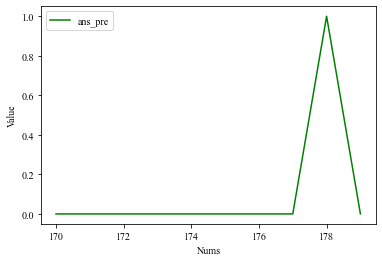

In [17]:
from matplotlib import pyplot as plt
plt.xlabel("Nums")
plt.ylabel("Value")
epoch_list=list(range(170,180))
plt.plot(epoch_list,ans_pre[170:180],color='green',label='ans_pre')
plt.legend()
plt.show()

In [45]:
import math
k=math.ceil(len(ans_pre)/10)
count_mp={'0':0,'1':0,'2':0,'3':0,'4':0,'5':0}
w=0
point=0
context=0
collective=0
for i in range(k):
    cnt=0
    t=i%6
    for k in range(w,min(w+10,len(ans_pre))):
        if ans_pre[k]==0 and ans_labels[k]==1:
            cnt=cnt+1
#             print(ans_labels[k-1],ans_labels[k],ans_labels[k+1])
            if (t==0 or t==5) and k-1>0 and k+1<len(ans_pre) and (ans_labels[k-1]==0 or ans_labels[k+1])==0:
                point=point+1
            elif ans_labels[k-1]==0 or ans_labels[k+1]==0:
                context=context+1
            elif ans_labels[k-1]==1 or ans_labels[k+1]==1:
                collective=collective+1
            
#     print(t,cnt)
    w=w+10
    count_mp[str(t)]=count_mp.get(str(t))+cnt
print(count_mp)
point,context,collective

{'0': 117, '1': 113, '2': 87, '3': 102, '4': 99, '5': 114}


(10, 50, 572)